In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from decimal import Decimal

from co2mpas.datasync import _get_interp_method
import collections

from sklearn import datasets, linear_model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from brokenaxes import brokenaxes

from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

In [2]:
input_file_1 = 'analysis_vehicles.xlsx'
input_file_2 = 'veh.xlsx'

CO2NOxPN = pd.read_excel(input_file_1, header=(0,1,2))          
regulated_pollutants = pd.read_excel(input_file_2, header=(0,1,2))

pd.set_option('precision', 3)
# pd.set_option("display.max_columns",54)      #display all the columns of the file

In [3]:
# CO2 complete
CO2 = pd.concat([CO2NOxPN.fuel,CO2NOxPN.TA_CO2,
                 CO2NOxPN.xs('CO2', level='pollutant',axis=1)],
                 axis=1)
CO2.columns = ['fuel','TA_CO2',
               'N_CD_23','N-10%_CD_23','N+10%_CD_23','N_CD_10','N_CD_30','N_HT_23','N_HT_AC18+L_23',
               'W_CD_23','W_HT_23','W_CD-7','W_HT-7',
               'ESP','ESD','LAB','LAD','MIL','SAC']                 

# NOx complete
NOx = pd.concat([CO2NOxPN.fuel,CO2NOxPN.TA_CO2,
                 CO2NOxPN.xs('NOx', level='pollutant',axis=1)],
                 axis=1)
NOx.columns = ['fuel','TA_CO2',
               'N_CD_23','N-10%_CD_23','N+10%_CD_23','N_CD_10','N_CD_30','N_HT_23','N_HT_AC18+L_23',
               'W_CD_23','W_HT_23','W_CD-7','W_HT-7',
               'ESP','ESD','LAB','LAD','MIL','SAC']         

# PN complete
PN = pd.concat([CO2NOxPN.fuel,CO2NOxPN.TA_CO2,
                 CO2NOxPN.xs('PN', level='pollutant',axis=1)],
                 axis=1)
PN.columns = ['fuel','TA_CO2',
               'N_CD_23','N-10%_CD_23','N+10%_CD_23','N_CD_10','N_CD_30','N_HT_23','N_HT_AC18+L_23',
               'W_CD_23','W_HT_23','W_CD-7','W_HT-7',
               'ESP','ESD','LAB','LAD','MIL','SAC']

# pd.set_option('display.float_format', lambda x: '%.2f' % x)   # use this to show CO2 or NOx

#pd.set_option('display.float_format', lambda x: '%.3e' % x)   # use this to how PN
#PN.iloc[:,2:].astype(float)                                  # Show PN in scientific

In [4]:
fuel = 'diesel'

if fuel == 'gasoline':
    NOx_lim = 60
    CO_lim = 1000
    PN_lim = 6e11
else:
    NOx_lim = 80
    CO_lim = 500
    PN_lim = 6e11
    
NOx_NTE = NOx_lim*2.1
PN_NTE = PN_lim*1.5

# 443/2009/EC
CO2_2015 = 130      # target EC for 2015
CO2_2020 = 95       # target EC for 2020


In [6]:
# CO2 complete
CO2 = pd.concat([regulated_pollutants.fuel,regulated_pollutants.T_A,
                 regulated_pollutants.xs(('CO2','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO2.columns = ['fuel','T-A','NEDC','WLTP','RDE']                 

# CO2 urban
CO2_urb = pd.concat([regulated_pollutants.fuel,#regulated_pollutants.T_A,
                 regulated_pollutants.NEDC.CO2.urban,regulated_pollutants.WLTP.CO2.low,
                 regulated_pollutants.RDE.CO2.urban], axis=1)
CO2_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# CO2 150s (g/KM)
CO2_150d = pd.concat([regulated_pollutants.fuel,#regulated_pollutants.T_A,
                 regulated_pollutants.xs(('CO2','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO2_150d.columns = ['fuel','NEDC','WLTP']

# CO2 150s (g)
CO2_150 = pd.concat([regulated_pollutants.fuel,#regulated_pollutants.T_A,
                 regulated_pollutants.xs(('CO2','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO2_150.columns = ['fuel','NEDC','WLTP','RDE']        
##############




# NOx complete
NOx = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('NOx','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
NOx.columns = ['fuel','NEDC','WLTP','RDE']                 

# NOx urban
NOx_urb = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.NEDC.NOx.urban,regulated_pollutants.WLTP.NOx.low,
                 regulated_pollutants.RDE.NOx.urban], axis=1)
NOx_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# NOx 150s (g/KM)
NOx_150d= pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('NOx','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
NOx_150d.columns = ['fuel','NEDC','WLTP']

# NOx 150s (g)
NOx_150 = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('NOx','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
NOx_150.columns = ['fuel','NEDC','WLTP','RDE']
##############




# CO complete
CO = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('CO','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO.columns = ['fuel','NEDC','WLTP','RDE']                 

# CO urban
CO_urb = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.NEDC.CO.urban,regulated_pollutants.WLTP.CO.low,
                 regulated_pollutants.RDE.CO.urban], axis=1)
CO_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# CO 150s (g/KM)
CO_150d = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('CO','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO_150d.columns = ['fuel','NEDC','WLTP'] 

# CO 150s (g)
CO_150 = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('CO','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO_150.columns = ['fuel','NEDC','WLTP','RDE']        
##############




# HC complete
HC = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('HC','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
HC.columns = ['fuel','NEDC','WLTP','RDE']                 

# HC urban
HC_urb = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.NEDC.HC.urban,regulated_pollutants.WLTP.HC.low,
                 regulated_pollutants.RDE.HC.urban], axis=1)
HC_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# HC 150s (g/KM)
HC_150d = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('HC','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
HC_150d.columns = ['fuel','NEDC','WLTP']

# HC 150s (g)
HC_150 = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('HC','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
HC_150.columns = ['fuel','NEDC','WLTP','RDE']
##############




# PN complete
PN = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('PN','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
PN.columns = ['fuel','NEDC','WLTP','RDE']                 

# PN urban
PN_urb = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.NEDC.PN.urban,regulated_pollutants.WLTP.PN.low,
                 regulated_pollutants.RDE.PN.urban], axis=1)
PN_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# PN 150s (g/KM)
PN_150d = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('PN','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
PN_150d.columns = ['fuel','NEDC','WLTP']

# PN 150s (g)
PN_150 = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('PN','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
PN_150.columns = ['fuel','NEDC','WLTP','RDE']

In [8]:
NOx_all = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs('NOx', level='pollutant',axis=1)],
                 axis=1)

NOx_all.columns = ['fuel',
                   'N_c','N_u','N_e','N_150d','N_150',
                   'W_c','W_l','W_m','W_h','W_eh','W_150d','W_150',
                   'R_c','R_u','R_r','R_m','R_150']

NOx_all[NOx_all.fuel=='diesel'].mean()

N_c        52.317
N_u        51.202
N_e        52.870
N_150d     94.625
N_150      60.972
W_c       155.376
W_l       145.656
W_m       100.120
W_h        69.096
W_eh      265.795
W_150d    189.720
W_150     127.092
R_c       381.839
R_u       291.245
R_r       344.153
R_m       531.979
R_150     295.696
dtype: float64

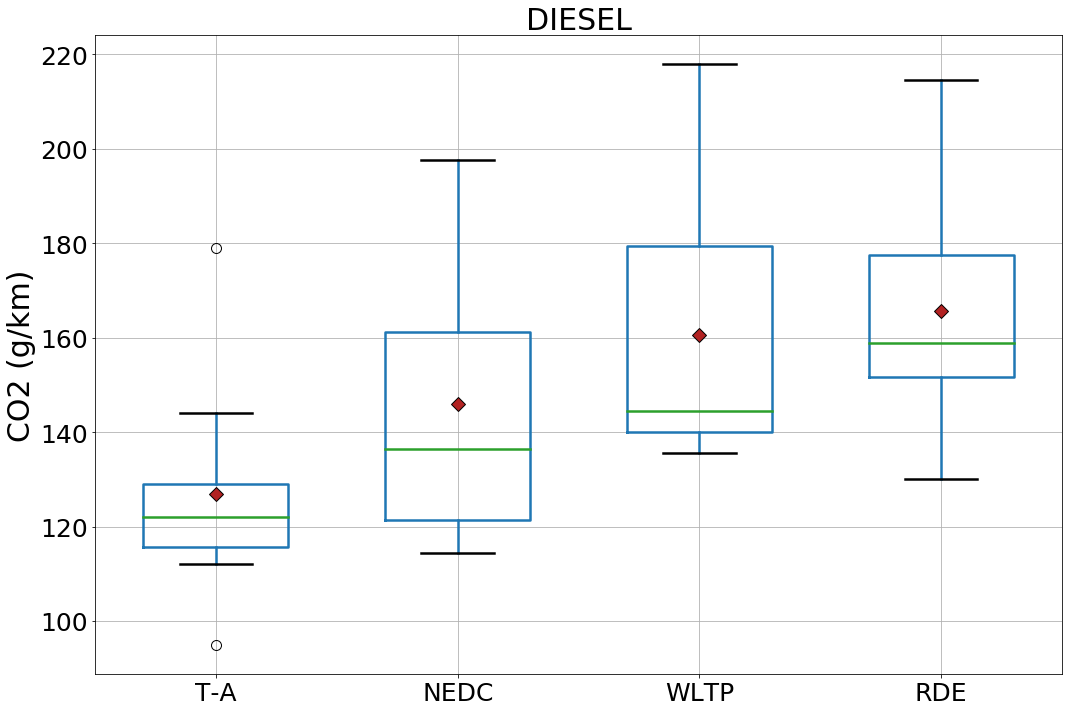

In [16]:
widths = 0.6                                                             # box
fs_ticks = 25                                                            # fonstize ticks  
fs_titles = 30                                                           # fontsize titles
fs_labels = 30                                                           # fontsize axis labels

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')      # median
meanpointprops = dict(marker='D', markeredgecolor='black',               # mean
                      markerfacecolor='firebrick', markersize = 10)
capprops = dict(linewidth=2.5)
whiskerprops = dict(linewidth=2.5, color='black')
flierprops = dict(markersize = 10)
boxprops = dict(linestyle='-', linewidth=2.5, color='black')

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
#       (ax3, ax4),
#       (ax5, ax6),
#       (ax7, ax8),
#       (ax9, ax10)) = plt.subplots(nrows=5, ncols=2, sharey='row',
#                                          figsize=(18,25))  # sharex='col'

# CO2
CO2[CO2['fuel']=='diesel'].boxplot(showmeans=True, 
                                   meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                   capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                   widths = widths, fontsize=25) 
# CO2_urb[CO2_urb['fuel']=='diesel'].boxplot(ax=ax2, showmeans=True, 
#                                            medianprops=medianprops, meanprops=meanpointprops, whiskerprops=whiskerprops, 
#                                            capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                            widths = widths, fontsize=25) 
# # CO2_150d[CO2_150d['fuel']=='diesel'].boxplot(ax=ax3, showmeans=True, widths = widths, capprops=capprops,
# #                                              meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# # NOx
# NOx[NOx['fuel']=='diesel'].boxplot(ax=ax3, showmeans=True, 
#                                    capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                    meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops, 
#                                    widths = widths, fontsize=25)
# NOx_urb[NOx_urb['fuel']=='diesel'].boxplot(ax=ax4, showmeans=True, 
#                                            capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                            meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                            widths = widths, fontsize=25)
# # NOx_150d[NOx_150d['fuel']=='diesel'].boxplot(ax=ax6, showmeans=True, widths = widths, capprops=capprops,
# #                                              meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# ax3.axhline(y=NOx_lim, color='r', linestyle='--', linewidth=2 )            # limits
# ax3.axhline(y=NOx_NTE, color='r', linestyle='--', linewidth=2 )             # conformity factor
# #ax4.axhline(y=NOx_lim, color='r', linestyle='--', linewidth=2 )
# #ax4.axhline(y=NOx_CF, color='r', linestyle='--', linewidth=2 )



# # CO
# CO[CO['fuel']=='diesel'].boxplot(ax=ax5, showmeans=True, 
#                                  capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                  meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops, 
#                                  widths = widths, fontsize=25); 
# CO_urb[CO_urb['fuel']=='diesel'].boxplot(ax=ax6, showmeans=True, 
#                                          capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                          meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                          widths = widths, fontsize=25) 
# # CO_150d[CO_150d['fuel']=='diesel'].boxplot(ax=ax9, showmeans=True, widths = widths, capprops=capprops,
# #                                            meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# # HC
# HC[HC['fuel']=='diesel'].boxplot(ax=ax7, showmeans=True, 
#                                  capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                  meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                  widths = widths, fontsize=25) 
# HC_urb[HC_urb['fuel']=='diesel'].boxplot(ax=ax8, showmeans=True, 
#                                          capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                          meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                          widths = widths, fontsize=25) 
# # HC_150d[HC_150d['fuel']=='diesel'].boxplot(ax=ax12, showmeans=True, widths = widths, capprops=capprops,
# #                                            meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# # PN
# PN[PN['fuel']=='diesel'].boxplot(ax=ax9, showmeans=True, 
#                                  capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                  meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                  widths = widths, fontsize=25) 
# PN_urb[PN_urb['fuel']=='diesel'].boxplot(ax=ax10, showmeans=True, 
#                                          capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                          meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                          widths = widths, fontsize=25)                              # CHECK outliers!
# # PN_150d[PN_150d['fuel']=='diesel'].boxplot(ax=ax15, showmeans=True, showfliers=False, capprops=capprops,
# #                                            meanprops=meanpointprops, medianprops=medianprops,
# #                                         widths = widths, fontsize=25)                            # CHECK outliers!

# 3 columns
ax1.set_title('DIESEL', fontsize=30)
#ax2.set_title('URBAN', fontsize=30)
#ax3.set_title('START', fontsize=30)

# 5 rows
ax1.set_ylabel('CO2 (g/km)', fontsize=30)
# ax3.set_ylabel('NOx (mg/km)', fontsize=30)
# ax5.set_ylabel('CO (mg/km)', fontsize=30)
# ax7.set_ylabel('HC (mg/km)', fontsize=30)
# ax9.set_ylabel('PN (#/km)', fontsize=30)
# ax9.set_yscale('log')
# ax10.set_yscale('log')


fig.tight_layout()

# Gasoline

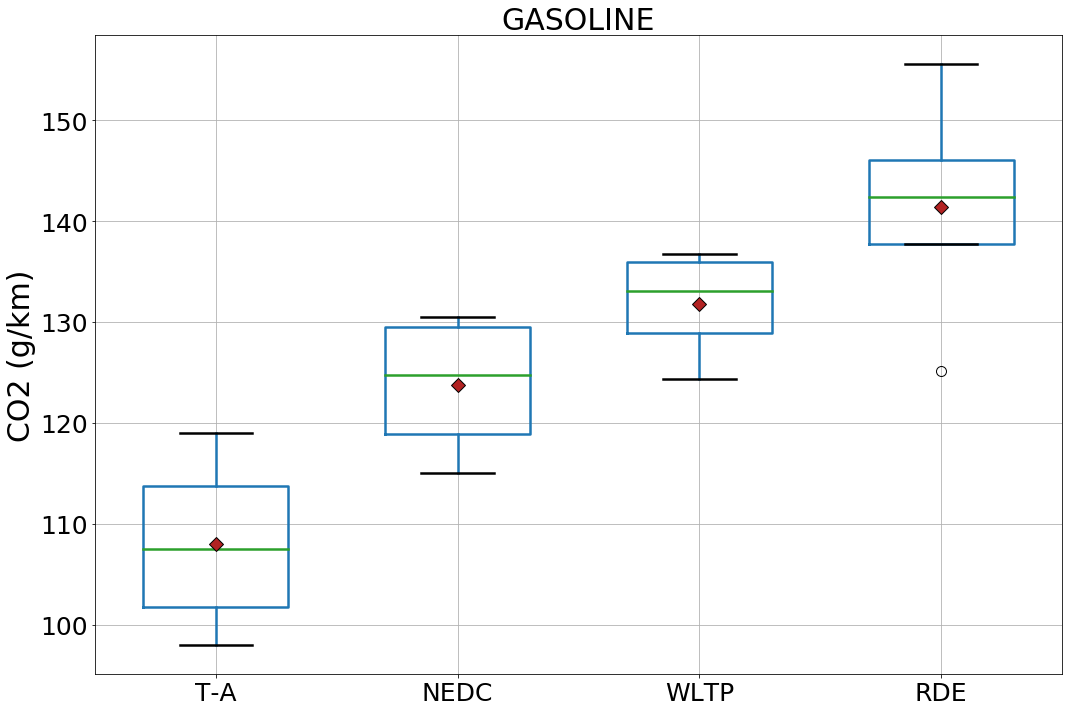

In [17]:
fuel = 'gasoline'

widths = 0.6                                                             # box
fs_ticks = 25                                                            # fonstize ticks  
fs_titles = 30                                                           # fontsize titles
fs_labels = 30                                                           # fontsize axis labels

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')      # median
meanpointprops = dict(marker='D', markeredgecolor='black',               # mean
                      markerfacecolor='firebrick', markersize = 10)
capprops = dict(linewidth=2.5)
whiskerprops = dict(linewidth=2.5, color='black')
flierprops = dict(markersize = 10)
boxprops = dict(linestyle='-', linewidth=2.5, color='black')

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,10))  # sharex='col'

# CO2
CO2[CO2['fuel']==fuel].boxplot(ax=ax1, showmeans=True, 
                                   meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                   capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                   widths = widths, fontsize=25) 
# CO2_urb[CO2_urb['fuel']==fuel].boxplot(ax=ax2, showmeans=True, 
#                                            medianprops=medianprops, meanprops=meanpointprops, whiskerprops=whiskerprops, 
#                                            capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                            widths = widths, fontsize=25) 
# # CO2_150d[CO2_150d['fuel']=='diesel'].boxplot(ax=ax3, showmeans=True, widths = widths, capprops=capprops,
# #                                              meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# # NOx
# NOx[NOx['fuel']==fuel].boxplot(ax=ax3, showmeans=True, 
#                                    capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                    meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops, 
#                                    widths = widths, fontsize=25)
# NOx_urb[NOx_urb['fuel']==fuel].boxplot(ax=ax4, showmeans=True, 
#                                            capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                            meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                            widths = widths, fontsize=25)
# # NOx_150d[NOx_150d['fuel']=='diesel'].boxplot(ax=ax6, showmeans=True, widths = widths, capprops=capprops,
# #                                              meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# ax3.axhline(y=NOx_lim, color='r', linestyle='--', linewidth=2 )            # limits
# ax3.axhline(y=NOx_CF, color='r', linestyle='--', linewidth=2 )             # conformity factor
# #ax4.axhline(y=NOx_lim, color='r', linestyle='--', linewidth=2 )
# #ax4.axhline(y=NOx_CF, color='r', linestyle='--', linewidth=2 )



# # CO
# CO[CO['fuel']==fuel].boxplot(ax=ax5, showmeans=True, 
#                                  capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                  meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops, 
#                                  widths = widths, fontsize=25); 
# CO_urb[CO_urb['fuel']==fuel].boxplot(ax=ax6, showmeans=True, 
#                                          capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                          meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                          widths = widths, fontsize=25) 
# # CO_150d[CO_150d['fuel']=='diesel'].boxplot(ax=ax9, showmeans=True, widths = widths, capprops=capprops,
# #                                            meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# # HC
# HC[HC['fuel']==fuel].boxplot(ax=ax7, showmeans=True, 
#                                  capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                  meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                  widths = widths, fontsize=25) 
# HC_urb[HC_urb['fuel']==fuel].boxplot(ax=ax8, showmeans=True, 
#                                          capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                          meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                          widths = widths, fontsize=25) 
# # HC_150d[HC_150d['fuel']=='diesel'].boxplot(ax=ax12, showmeans=True, widths = widths, capprops=capprops,
# #                                            meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# # PN
# PN[PN['fuel']==fuel].boxplot(ax=ax9, showmeans=True, 
#                                  capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                  meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                  widths = widths, fontsize=25) 
# PN_urb[PN_urb['fuel']==fuel].boxplot(ax=ax10, showmeans=True, 
#                                          capprops=capprops, flierprops=flierprops, boxprops=boxprops,
#                                          meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
#                                          widths = widths, fontsize=25)                              # CHECK outliers!
# # PN_150d[PN_150d['fuel']=='diesel'].boxplot(ax=ax15, showmeans=True, showfliers=False, capprops=capprops,
# #                                            meanprops=meanpointprops, medianprops=medianprops,
# #                                         widths = widths, fontsize=25)                            # CHECK outliers!



# # 3 columns
ax1.set_title('GASOLINE', fontsize=30)
# ax2.set_title('URBAN', fontsize=30)
# #ax3.set_title('START', fontsize=30)

# # 5 rows
ax1.set_ylabel('CO2 (g/km)', fontsize=30)
# ax3.set_ylabel('NOx (mg/km)', fontsize=30)
# ax5.set_ylabel('CO (mg/km)', fontsize=30)
# ax7.set_ylabel('HC (mg/km)', fontsize=30)
# ax9.set_ylabel('PN (#/km)', fontsize=30)
# ax9.set_yscale('log')
# ax10.set_yscale('log')


fig.tight_layout()

In [22]:
CO2[CO2['fuel']=='gasoline'].describe()

,T-A,NEDC,WLTP,RDE
count,4.000,4.000,4.000,4.000
mean,108.000,123.741,131.804,141.400
std,9.345,7.395,5.665,12.464
min,98.000,115.010,124.355,125.178
25%,101.750,118.937,128.953,137.773
50%,107.500,124.715,133.062,142.433
75%,113.750,129.518,135.914,146.060
max,119.000,130.525,136.738,155.556


In [25]:
CO2[CO2['fuel']=='diesel'].describe()

,T-A,NEDC,WLTP,RDE
count,8.000,8.000,8.000,8.000
mean,126.875,145.879,160.666,165.563
std,25.097,32.542,30.441,27.775
min,95.000,114.343,135.524,130.181
25%,115.750,121.374,140.049,151.748
50%,122.000,136.519,144.554,158.814
75%,129.000,161.144,179.367,177.618
max,179.000,197.611,217.873,214.646
